In [181]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from shapely.geometry import Point
import geopandas
import matplotlib.pyplot as plt

In [182]:
# https://math.stackexchange.com/q/444700/593484
# See alternative method 1: https://corysimon.github.io/articles/uniformdistn-on-sphere/
# NUM_WORLD_LOCATIONS = 37067
NUM_WORLD_LOCATIONS = 1200
# in miles:
MEAN_RADIUS_OF_EARTH = 3958.7613
DATA_PATH = Path("../data/")
print(f"DATA_PATH: {DATA_PATH}")


DATA_PATH: ../data


In [183]:
def get_uniformly_distributed_points_on_sphere(n:int):
    """The points are returned with respect to the
    standard basis for R^3 as an numpy.ndarray.
    x, y, and z-coordinates are in the 0, 1, and 2 columns,
    respectively. 
    Each row represents a different point.

    References:
    https://math.stackexchange.com/q/444700/593484
    See alternative method 1: https://corysimon.github.io/articles/uniformdistn-on-sphere/
    https://gis.stackexchange.com/a/356502
    """
    # The user desires n points.  However, it is hard to generate
    # exactly n points in a numerically stable way.  Therefore,
    # we try to generate int(n * n_safety) points.
    vecs_on_sphere = np.empty(shape=(n, 3))
    n_safety = 1.01
    num_points_generated = 0

    while num_points_generated < n:
        # Generate int(n * n_safety) vectors.
        # Store these vectors as columns in a matrix V
        # for further manipulation.
        # Only take those columns with a large enough norm.
        V = stats.norm.rvs(size=(int(n * n_safety), 3))
        norms_of_V_rows = np.linalg.norm(x=V, ord=2, axis=1, keepdims=False)
        good_rows_of_V = norms_of_V_rows > 0.0001

        # https://stackoverflow.com/a/49763264/8423001
        num_points_generated = np.count_nonzero(good_rows_of_V)
        if num_points_generated < n:
            n_safety = n_safety + 0.01
            # continue with next iteration of loop
            continue
        # We found the number of vectors required by n
        # that meet our numerical requirement of being long enough.
        # Save them.
        vecs = V[good_rows_of_V, :][0:n, :] 
        norms_of_vecs = norms_of_V_rows[good_rows_of_V][0:n]
        # https://stackoverflow.com/questions/19602187/numpy-divide-each-row-by-a-vector-element
        vecs_on_sphere = vecs / norms_of_vecs.reshape(-1, 1)
        # The vectors can now
        # be stretched so that they land on the unit-sphere.
        
    return vecs_on_sphere

    # np.apply_along_axis(
    #     func1d=cartesian_to_gcs,
    #     axis=0,
    #     arr=vecs_on_sphere
    # )

def get_central_angle(n1, n2):
    """Given the so-called n-vectors n1 and n2,
    find the central angle between them.
    Returns the angle in radians.
    
    Args:
        n1: numpy.ndarray
        n2: numpy.ndarray

    See: https://en.m.wikipedia.org/wiki/N-vector
    """
    delta_sigma = np.arctan2(
        np.linalg.norm(
            np.abs(np.cross(n1, n2)), 
            ord=2
        ),
        np.dot(n1, n2)
    ) 

    return delta_sigma

def great_circle_dist(p, q, r):
    """Given points p and q represented
    as n-vectors on a sphere
    with radius r, find the great-circle
    distance between them.

    Args:
        p: numpy.ndarray
        q: numpy.ndarray

    See: https://en.m.wikipedia.org/wiki/N-vector
    """
    delta_sigma = get_central_angle(n1=p, n2=q)
    d = r * np.abs(delta_sigma)

    return d

def great_circle_dist_matrix(vecs, r):
    """Given a set of n-vectors on a sphere of
    radius r, construct the symmetric matrix 
    showing all of their
    pair-wise great-circle distances.
    For simplicity, garbage is returned along
    the main diagonal and the lower triangular matrix.
    Only refer to the upper triangular matrix of the
    output.

    Args:
        vecs: numpy.ndarray. This should be a 
        matrix with each row representing an
        n-vector. It should have 3 columns
        for the x, y, and z coordinates of
        each point.
    Returns:
        numpy.ndarray
    """
    num_vecs = vecs.shape[0]
    dist_mat = np.empty(shape=(num_vecs, num_vecs))

    # Fill upper triangle.
    for i in range(num_vecs):
        for j in range(i + 1, num_vecs, 1):
            # Get distance for ith row and jth col.
            dist_mat[i, j] = great_circle_dist(p=vecs[i], q=vecs[j], r=r)

    return dist_mat

def to_lat_long(v):
    """Convert n-vectors to their two-dimensional
    representation on a sphere.
    
    Converts to latitudes and longitudes.

    Args:
        v: numpy.ndarray.  This should be a matrix
        with rows representing n-vectors and columns
        representing x, y, and z coordinates.

    Returns:
        numpy.ndarray with two columns and the same
        number of rows as v.  The 1st column is the
        latitude and the 2nd col is the longitude.

    See: https://en.m.wikipedia.org/wiki/N-vector
    """
    n_x = v[:, 0]
    n_y = v[:, 1]
    n_z = v[:, 2]
    latitude = np.arctan2(n_z, np.sqrt(n_x**2 + n_y**2)) * 180 / np.pi
    longitude = np.arctan2(n_y, n_x) * 180 / np.pi

    return np.column_stack((latitude, longitude))

def to_n_vector(p):
    """Given a matrix p 
    where each row of p represents a point
    in geocentric coordinates (such as in the WGS 84 CRS),
    and where the 0th column is the latitude
    and the 1st column is the longitude,
    find the associated n-vector for each row of p.
    Everything should be in degrees.

    Args:
        p: numpy.ndarray

    Returns:
        numpy.ndarray

    See: 
    https://en.wikipedia.org/wiki/N-vector#Converting_latitude/longitude_to_n-vector
    https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_ECEF_to_geodetic_coordinates
    """
    latitude = p[:, 0]
    longitude = p[:, 1]

    latitude_in_radians = latitude * np.pi / 180
    longitude_in_radians = longitude * np.pi / 180
    # trig functions are in radians
    x = np.cos(latitude_in_radians) * np.cos(longitude_in_radians)
    y = np.cos(latitude_in_radians) * np.sin(longitude_in_radians)
    z = np.sin(latitude_in_radians)

    return np.column_stack((x, y, z))



# Test Functions

In [184]:
my_points = get_uniformly_distributed_points_on_sphere(10)
my_points

array([[-0.34210557, -0.60102518, -0.72231053],
       [ 0.86328881, -0.50427111, -0.02104947],
       [ 0.53034867,  0.32909314, -0.78129891],
       [-0.49563744, -0.07549561, -0.86524213],
       [ 0.85733416,  0.36379488, -0.36418598],
       [-0.75759651, -0.48946284, -0.43182594],
       [-0.48071551,  0.71122459,  0.51290562],
       [-0.8705039 , -0.34681683, -0.34920058],
       [ 0.75930271,  0.5595534 ,  0.33220384],
       [-0.72699064,  0.68262821, -0.07418452]])

In [185]:
my_points_as_lat_long = to_lat_long(my_points)
my_points_as_lat_long

array([[ -46.24557334, -119.64867899],
       [  -1.20613508,  -30.29039408],
       [ -51.37965706,   31.82052092],
       [ -59.91036479, -171.33926486],
       [ -21.35749532,   22.99309806],
       [ -25.58349512, -147.13457871],
       [  30.85756632,  124.05469468],
       [ -20.43842694, -158.27720382],
       [  19.40259416,   36.38763771],
       [  -4.254368  ,  136.80257318]])

In [186]:
my_points_as_n_vec = to_n_vector(my_points_as_lat_long)
my_points_as_n_vec

array([[-0.34210557, -0.60102518, -0.72231053],
       [ 0.86328881, -0.50427111, -0.02104947],
       [ 0.53034867,  0.32909314, -0.78129891],
       [-0.49563744, -0.07549561, -0.86524213],
       [ 0.85733416,  0.36379488, -0.36418598],
       [-0.75759651, -0.48946284, -0.43182594],
       [-0.48071551,  0.71122459,  0.51290562],
       [-0.8705039 , -0.34681683, -0.34920058],
       [ 0.75930271,  0.5595534 ,  0.33220384],
       [-0.72699064,  0.68262821, -0.07418452]])

In [187]:
get_central_angle(my_points_as_n_vec[0, :], my_points_as_n_vec[1, :])

1.5478463339106672

In [188]:
great_circle_dist_matrix(my_points_as_n_vec, MEAN_RADIUS_OF_EARTH)

array([[0.00000000e+000, 6.12755417e+003, 5.48134271e+003,
        2.27106828e+003, 7.21418437e+003, 2.07877637e+003,
        8.93431470e+003, 2.80999609e+003, 1.01375506e+004,
        6.64672949e+003],
       [4.94065646e-323, 5.43472210e-323, 4.97755280e+003,
        7.72561331e+003, 3.84459363e+003, 7.83935730e+003,
        9.78840710e+003, 8.61583644e+003, 4.73359282e+003,
        1.14691034e+004],
       [9.88131292e-323, 1.03753786e-322, 1.08694442e-322,
        4.63967860e+003, 2.12818055e+003, 7.11878770e+003,
        7.94138521e+003, 7.43696771e+003, 4.89842189e+003,
        6.62668547e+003],
       [1.48219694e-322, 1.53160350e-322, 1.58101007e-322,
        1.63041663e-322, 6.76359914e+003, 2.63794332e+003,
        7.25645762e+003, 2.80209374e+003, 9.32152866e+003,
        4.70531247e+003],
       [1.97626258e-322, 2.02566915e-322, 2.07507571e-322,
        2.12448228e-322, 2.17388884e-322, 9.12663175e+003,
        7.59255610e+003, 9.54771851e+003, 2.95821804e+003,
        7.6

# Get and Plot World Locations

In [8]:
# https://ecoregions.appspot.com/
ecoregions_2017 = geopandas.read_file(filename=Path(DATA_PATH, "raw_data", "Ecoregions2017"))

In [ ]:
type(ecoregions_2017)

geopandas.geodataframe.GeoDataFrame

In [9]:
ecoregions_2017.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

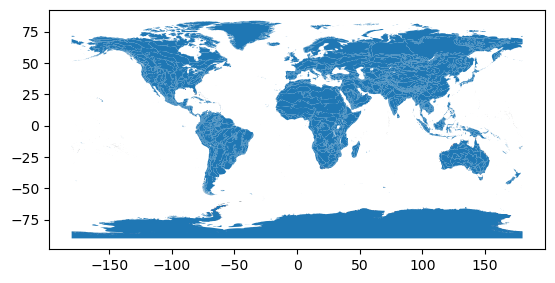

In [ ]:
ecoregions_2017.plot()

In [ ]:
ecoregions_2017.drop(
    columns=[
        "NNH",
        "SHAPE_LENG",
        "NNH_NAME",
        "COLOR_BIO",
        "COLOR_NNH",
        "LICENSE"
    ],
    inplace = True
)

In [189]:
ecoregions_2017.head

<bound method NDFrame.head of      OBJECTID                                           ECO_NAME  BIOME_NUM  \
0         1.0                                 Adelie Land tundra       11.0   
1         2.0             Admiralty Islands lowland rain forests        1.0   
2         3.0  Aegean and Western Turkey sclerophyllous and m...       12.0   
3         4.0                       Afghan Mountains semi-desert       13.0   
4         5.0                   Ahklun and Kilbuck Upland Tundra       11.0   
..        ...                                                ...        ...   
842     848.0                      Sulawesi lowland rain forests        1.0   
843     212.0                       East African montane forests        1.0   
844     224.0                                Eastern Arc forests        1.0   
845      79.0                        Borneo montane rain forests        1.0   
846     376.0                    Kinabalu montane alpine meadows       10.0   

                     

In [190]:
# https://geopandas.org/en/stable/docs/user_guide/data_structures.html
ecoregions_2017 = ecoregions_2017.rename(columns={'geometry': 'ecoregion_border'}).set_geometry('ecoregion_border')

In [191]:
# Find a representative point within each ecoregion.
ecoregion_rep_points = ecoregions_2017.representative_point()

In [192]:
ecoregions_2017.head

<bound method NDFrame.head of      OBJECTID                                           ECO_NAME  BIOME_NUM  \
0         1.0                                 Adelie Land tundra       11.0   
1         2.0             Admiralty Islands lowland rain forests        1.0   
2         3.0  Aegean and Western Turkey sclerophyllous and m...       12.0   
3         4.0                       Afghan Mountains semi-desert       13.0   
4         5.0                   Ahklun and Kilbuck Upland Tundra       11.0   
..        ...                                                ...        ...   
842     848.0                      Sulawesi lowland rain forests        1.0   
843     212.0                       East African montane forests        1.0   
844     224.0                                Eastern Arc forests        1.0   
845      79.0                        Borneo montane rain forests        1.0   
846     376.0                    Kinabalu montane alpine meadows       10.0   

                     

In [193]:
num_ecoregions = ecoregions_2017.shape[0]


In [194]:
num_additional_spots_wanted = max(0, NUM_WORLD_LOCATIONS - num_ecoregions)
# Get even more locations than we want because
# some will land in the ocean.
possible_additional_spots = get_uniformly_distributed_points_on_sphere(n=6*num_additional_spots_wanted)

# Convert to geographic coordinate system
possible_additional_spots_lat_long = to_lat_long(possible_additional_spots)

# Important!
# Point objects have longitude first and latitude second.
# x represents longitude.
# y represents latitude.
possible_additional_spots_geom_array = geopandas.points_from_xy(x=possible_additional_spots_lat_long[:, 1], y=possible_additional_spots_lat_long[:, 0], crs="EPSG:4326")
# additional_spots_with_rep_points = pd.concat((additional_points_on_earth, ecoregion_rep_points))

In [195]:
num_additional_spots_wanted

353

In [196]:
possible_additional_spots_geoseries = geopandas.GeoSeries(data=possible_additional_spots_geom_array, crs="EPSG:4326")

In [197]:
rep_and_additional_points = pd.concat((ecoregion_rep_points, possible_additional_spots_geoseries))

In [198]:
rep_and_additional_points_gdf = geopandas.GeoDataFrame(geometry=rep_and_additional_points, crs="EPSG:4326")
# https://gis.stackexchange.com/a/393428/234035
# Save the geometry for access after the join.
rep_and_additional_points_gdf["extra_points_geom"] = rep_and_additional_points

<Axes: >

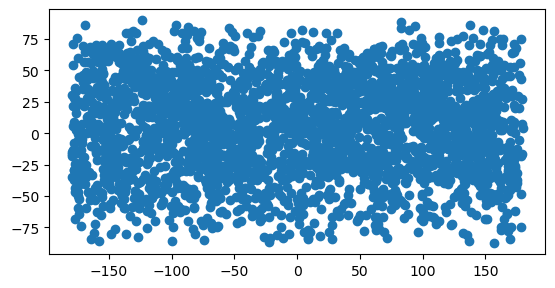

In [199]:
rep_and_additional_points_gdf.plot()

In [214]:
# https://geopandas.org/en/stable/gallery/spatial_joins.html
# The advantage of doing it this way is that I have the points
# and I have meta-information about them.
ecoregions_2017_with_more_points = ecoregions_2017.sjoin(rep_and_additional_points_gdf, predicate="contains", how="inner")

In [215]:
print(f"The actual number of total world locations: ", ecoregions_2017_with_more_points.shape[0])

The actual number of total world locations:  1461


In [119]:
# https://www.linkedin.com/pulse/geopandas-plotting-data-points-map-using-python-r%C3%A9gis-nisengwe/
# https://stackoverflow.com/questions/9622163/save-plot-to-image-file-instead-of-displaying-it
fig, ax = plt.subplots(figsize=(8,8))

# https://gis.stackexchange.com/questions/336437/colorizing-polygons-based-on-color-values-in-dataframe-column
ecoregions_2017_with_more_points.set_geometry("ecoregion_border", inplace = True)
ecoregions_2017_with_more_points.plot(ax=ax, color=ecoregions_2017_with_more_points["COLOR"])
# Change active geometry for next plot.
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter
ecoregions_2017_with_more_points.set_geometry("extra_points_geom", inplace = True)
ecoregions_2017_with_more_points.plot(ax=ax, color='Red', marker=".", markersize=3, linewidth=0)
fig.savefig(fname=Path(DATA_PATH, "world_locations.png"), dpi=600)  
plt.close(fig)    

In [216]:
# First, change the other geometry to a WKT string.
# https://gis.stackexchange.com/questions/378549/quick-way-to-get-wkt-from-a-geodataframes-geometries-in-geopandas
ecoregions_2017_with_more_points.set_geometry("ecoregion_border", inplace = True)
ecoregions_2017_with_more_points['extra_points_geom'] = ecoregions_2017_with_more_points['extra_points_geom'].to_wkt()

In [217]:
ecoregions_2017_with_more_points.drop(
    columns=[
        "ECO_BIOME_",
        "ECO_BIOME_",
        "SHAPE_AREA",
        "ecoregion_rep_point"
    ],
    inplace = True
)

In [219]:
# Save the GeoDataFrame to a file.
# An ESRI shapefile is written.
ecoregions_2017_with_more_points.to_file(filename=str(Path(DATA_PATH, "ecoregions_2017_with_more_points.shp")), encoding='utf-8')  

/tmp/ipykernel_4046/3689165235.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ecoregions_2017_with_more_points.to_file(filename=str(Path(DATA_PATH, "ecoregions_2017_with_more_points.shp")), encoding='utf-8')


In [222]:
print(ecoregions_2017_with_more_points.columns)
print([len(i) for i in ecoregions_2017_with_more_points.columns])

Index(['OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_ID',
       'COLOR', 'ecoregion_border', 'index_right', 'extra_points_geom'],
      dtype='object')
[8, 8, 9, 10, 5, 6, 5, 16, 11, 17]


# Get Efficient Distance Matrix for World Locations

In [223]:
rep_and_additional_points_longs_lats = rep_and_additional_points.get_coordinates().to_numpy()
# We have to switch it around. Annoying.
rep_and_additional_points_lats_longs = np.column_stack((
    rep_and_additional_points_longs_lats[:, 1],
    rep_and_additional_points_longs_lats[:, 0]
))

rep_and_additional_points_n_vector = to_n_vector(rep_and_additional_points_lats_longs)
dist_matrix = great_circle_dist_matrix(rep_and_additional_points_n_vector, r=MEAN_RADIUS_OF_EARTH)

In [224]:
dist_mat = dist_matrix.round(decimals=0)

In [225]:
neg_indices = np.argwhere(dist_mat < 0)
problem_indices = np.argwhere(neg_indices[:, 1] > neg_indices[:, 0])

In [226]:
problem_indices

array([], shape=(0, 1), dtype=int64)

In [227]:
np.savetxt(fname=Path(DATA_PATH, "dist_matrix.csv"), X=dist_mat, delimiter=",")